<a href="https://colab.research.google.com/github/LatifulJoy/COVID19-detection-using-CNN_transfer_learning/blob/main/covid_detection_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the libraries

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [5]:
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# re-size all the images
IMAGE_SIZE = [224, 224]
train_path = '/content/drive/MyDrive/Colab Notebooks/CovidDataset/Train'
valid_path ='/content/drive/MyDrive/Colab Notebooks/CovidDataset/Val'

In [13]:
# Import the Vgg 19 library as shown below and add preprocessing layer to the front of VGG
# we will be using imagenet weights

vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [14]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
# we shouldn't train existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [19]:
folders = glob('/content/drive/MyDrive/Colab Notebooks/CovidDataset/Train/*')

In [20]:
folders

['/content/drive/MyDrive/Colab Notebooks/CovidDataset/Train/Normal',
 '/content/drive/MyDrive/Colab Notebooks/CovidDataset/Train/Covid']

In [21]:
# our layers
x = Flatten()(vgg19.output)

In [22]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [23]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
from tensorflow.keras.layers import MaxPooling2D

In [25]:
### Create Model from scratch using CNN
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0

In [28]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [29]:
#data augmentation
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
# provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/CovidDataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 224 images belonging to 2 classes.


In [31]:
training_set

In [32]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/CovidDataset/Val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 60 images belonging to 2 classes.


In [33]:
# fit the model
# Run the cell
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
7/7 [==============================] - 73s 10s/step - loss: 1.2181 - accuracy: 0.6562 - val_loss: 0.3434 - val_accuracy: 0.8667
Epoch 2/10
7/7 [==============================] - 18s 2s/step - loss: 0.4361 - accuracy: 0.8170 - val_loss: 0.2166 - val_accuracy: 0.9333
Epoch 3/10
7/7 [==============================] - 17s 2s/step - loss: 0.2212 - accuracy: 0.9241 - val_loss: 0.1377 - val_accuracy: 0.9500
Epoch 4/10
7/7 [==============================] - 17s 2s/step - loss: 0.1740 - accuracy: 0.9375 - val_loss: 0.1093 - val_accuracy: 0.9667
Epoch 5/10
7/7 [==============================] - 17s 2s/step - loss: 0.1015 - accuracy: 0.9554 - val_loss: 0.1018 - val_accuracy: 0.9667
Epoch 6/10
7/7 [==============================] - 17s 2s/step - loss: 0.0548 - accuracy: 0.9821 - val_loss: 0.0865 - val_accuracy: 0.9667
Epoch 7/10
7/7 [==============================] - 18s 3s/step - loss: 0.0516 - accuracy: 0.9866 - val_loss: 0.1111 - val_accuracy: 0.9667
Epoch 8/10
7/7 [=================

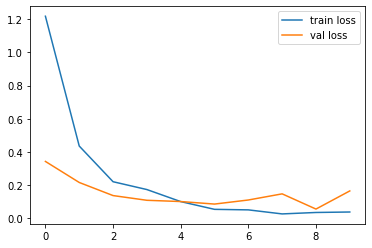

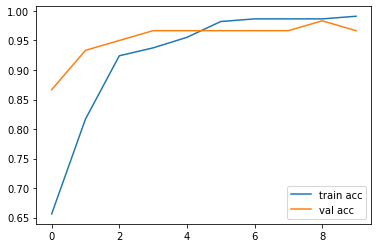

<Figure size 432x288 with 0 Axes>

In [34]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [110]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')

In [111]:
y_pred = model.predict(test_set)

In [112]:
y_pred

array([[1.47765313e-04, 9.99852180e-01],
       [9.99917150e-01, 8.28456177e-05],
       [1.40530802e-03, 9.98594701e-01],
       [7.77381574e-05, 9.99922276e-01],
       [9.97840643e-01, 2.15933099e-03],
       [9.99505639e-01, 4.94350796e-04],
       [1.24208843e-02, 9.87579167e-01],
       [7.20428419e-04, 9.99279559e-01],
       [4.21659897e-05, 9.99957800e-01],
       [1.14765894e-02, 9.88523424e-01],
       [9.98207211e-01, 1.79280527e-03],
       [9.99997258e-01, 2.70829878e-06],
       [9.99774158e-01, 2.25858021e-04],
       [9.95632708e-01, 4.36722673e-03],
       [2.57779429e-05, 9.99974251e-01],
       [9.99710143e-01, 2.89801159e-04],
       [2.94467929e-04, 9.99705493e-01],
       [1.45946238e-02, 9.85405385e-01],
       [9.99998331e-01, 1.70736007e-06],
       [9.87356305e-01, 1.26436865e-02],
       [1.16387894e-02, 9.88361180e-01],
       [9.99335349e-01, 6.64662977e-04],
       [9.99834061e-01, 1.65915029e-04],
       [3.12796086e-02, 9.68720376e-01],
       [8.525214

In [113]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [114]:
y_pred

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0])